In [2]:
import numpy as np #type: ignore
import matplotlib.pyplot as plt #type: ignore
import pandas as pd 
import random
import umap #type: ignore
import librosa #type: ignore
import librosa.display #type: ignore
import tensorflow as tf #type: ignore
import re
import bisect
import tqdm

from sklearn.model_selection import train_test_split #type: ignore
from sklearn.manifold import TSNE #type: ignore
from sklearn.decomposition import PCA #type: ignore
from sklearn.preprocessing import LabelEncoder, StandardScaler #type: ignore

# from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models #type: ignore

from collections import Counter


In [9]:
# read in data
def reading_data(size):
    train_df = pd.read_csv(f"./data/{size}/debug_train_{size}_{size}.csv")
    val_df = pd.read_csv(f"./data/{size}/debug_val_{size}_{size}.csv")
    test_df = pd.read_csv(f"./data/{size}/debug_test_{size}_{size}.csv")

    return train_df, val_df, test_df

train_32, val_32, test_32 = reading_data(32)
train_64, val_64, test_64 = reading_data(64)


In [10]:
train_256, val_256, test_256 = reading_data(256)

In [ ]:
# check sizes: (n observations, size*size)
print("train_32 shape:", train_32.shape)
print("train_64 shape:", train_64.shape)
print("train_256 shape:", train_256.shape)

train_32 shape: (600, 1025)
train_64 shape: (600, 4097)
train_256 shape: (600, 65537)


In [26]:
def get_xy(df):
    X = df.drop("labels", axis = 1).copy()
    y = df["labels"]

    return X, y

In [27]:
# get variables for each dataset
# 32
X_train_32, y_train_32 = get_xy(train_32)
X_val_32, y_val_32 = get_xy(val_32)
X_test_32, y_test_32 = get_xy(test_32)

# 64
X_train_64, y_train_64 = get_xy(train_64)
X_val_64, y_val_64 = get_xy(val_64)
X_test_64, y_test_64 = get_xy(test_64)

# 256
X_train_256, y_train_256 = get_xy(train_256)
X_val_256, y_val_256 = get_xy(val_256)
X_test_256, y_test_256 = get_xy(test_256)

In [31]:
print(X_train_32["0"].min(), X_train_32["0"].max())

-2.7274363 1.915653


In [32]:
print(f"Shape of X train (32): {X_train_32.shape}")
print(f"Shape of y_train (32): {y_train_32.shape}")
print(f"Shape of X_val (32): {X_val_32.shape}")

Shape of X train (32): (600, 1024)
Shape of y_train (32): (600,)
Shape of X_val (32): (200, 1024)


# Flat NN

#### Data preprocessing

In [22]:
# splitting data into test, validation and test dataset: 60/20/20
# after shuffling
def split_data(X, y, split):
# shuffling
    tf.random.set_seed(1234)
    np.random.seed(1234)

    N = X.shape[0]
    indices = np.arange(N)

    shuffled_indices = np.random.permutation(indices)
    shuffled_X = X[shuffled_indices]
    shuffled_y = y[shuffled_indices]

    val_frac = split[1]/(split[1] + split[2])

    X_train, X_temp, y_train, y_temp = train_test_split(shuffled_X, shuffled_y, test_size = 1-split[0], random_state=1234)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size = 1-val_frac, random_state = 1234)

    return X_train, y_train, X_val, y_val, X_test, y_test

In [23]:
split = (.6, .2, .2)

X_class_train, y_class_train, X_class_val, y_class_val, X_class_test, y_class_test = split_data(X, y_class, split)
X_spec_train, y_spec_train, X_spec_val, y_spec_val, X_spec_test, y_spec_test = split_data(X, y_species, split)

In [24]:
np.unique(y_class_train)

array(['Amphibia', 'Aves', 'Insecta', 'Mammalia'], dtype='<U8')

In [38]:
def encode_with_unknown_handling(le, y_train, y_val, y_test):
    # Fit encoder on training labels
    y_train_enc = le.fit_transform(y_train)
    
    # Create a mapping for known classes
    known_classes = set(le.classes_)
    
    # Replace unknown labels with 'other'
    def replace_unknown(labels):
        return np.array([lbl if lbl in known_classes else "other" for lbl in labels])
    
    # Add "other" to classes if not present
    classes = list(le.classes_)
    if "other" not in classes:
        classes.append("other")
        le.classes_ = np.array(classes)
    
    y_val_fixed = replace_unknown(y_val)
    y_test_fixed = replace_unknown(y_test)
    
    # encode
    y_val_enc = le.transform(y_val_fixed)
    y_test_enc = le.transform(y_test_fixed)
    
    return y_train_enc, y_val_enc, y_test_enc


In [39]:
le_spec = LabelEncoder()
y_spec_train_int, y_spec_val_int, y_spec_test_int = encode_with_unknown_handling(
    le_spec, y_spec_train, y_spec_val, y_spec_test)

In [40]:
le_class = LabelEncoder()
y_class_train_int, y_class_val_int, y_class_test_int = encode_with_unknown_handling(
    le_class, y_class_train, y_class_val, y_class_test
)

In [41]:
# check shapes
print(f"Shape of X_class_train: {X_class_train.shape}")
print(f"Shape of X_spec_train: {X_spec_train.shape}")
print(f"Shape of y_class_train encoded: {y_class_train_int.shape}")
print(f"Shape of y_spec_train encoded: {y_spec_train_int.shape}")

Shape of X_class_train: (600, 256, 256)
Shape of X_spec_train: (600, 256, 256)
Shape of y_class_train encoded: (600,)
Shape of y_spec_train encoded: (600,)


### Model

In [43]:
def build_flat_nn(n_classes, 
                  learning_rate, 
                  hidden_layer_sizes = [], 
                  metric = 'metric') :
    """num_class: number of classes to predic
    the model takes in the input dimension and number of classes to predict
    and returns flat nn model with the multi-class predictions"""

    # building model
    tf.keras.backend.clear_session()
    np.random.seed(1234)
    tf.random.set_seed(1234)

    model = models.Sequential()

    model.add(tf.keras.layers.Flatten(input_shape = (256, 256)))

    for units in hidden_layer_sizes:
        model.add(tf.keras.layers.Dense(units, activation = "relu"))

    model.add(layers.Dropout(.3))
    model.add(layers.Dense(256, activation = "relu"))
    model.add(layers.Dense(n_classes, activation = "softmax"))

    # compile model
    opt = tf.keras.optimizers.Adam(learning_rate = learning_rate)
    model.compile(optimizer = opt,
                  loss = "sparse_categorical_crossentropy",
                  metrics = [metric])

    return model

In [52]:
def train_and_evaluate(type = "class",
                       learning_rate=0.01,
                       n_classes = 4,
                       metric='accuracy',
                       hidden_layer_sizes = [],
                       num_epochs=10):

  # Build the model.
    model = build_flat_nn(n_classes = n_classes,
                          metric=metric,
                          hidden_layer_sizes=hidden_layer_sizes,
                          learning_rate=learning_rate)

  # Select the dataset.
    if type == "class":
        X_train = X_class_train
        X_val = X_class_val
        y_train = y_class_train_int
        y_val = y_class_val_int
    
    elif type == "species":
        X_train = X_spec_train
        X_val = X_spec_val
        y_train = y_spec_train_int
        y_val = y_spec_val_int
    else:
        raise 'Unsupported dataset: %s' %data

  # Train the model.
    print('Training the', data, 'model...')
    history = model.fit(
        x=X_train,
        y=y_train,
        validation_data = (X_val, y_val),
        epochs=num_epochs,
        batch_size=64,
        validation_split=0.1,
        verbose=0)

    # Retrieve the training metrics (after each train epoch) and the final validation
    # accuracy.
    train_accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    plt.plot(train_accuracy, label='train_accuracy')
    plt.plot(val_accuracy, label='validation accuracy')
    plt.xticks(range(num_epochs))
    plt.xlabel('Train epochs')
    plt.legend()
    plt.show()
    
    print('Training accuracy: %1.4f' %train_accuracy[-1])
    print('Validation accuracy: %1.4f' %val_accuracy[-1])
    
    return model



/Users/woojungkim/Library/Caches/pypoetry/virtualenvs/datasci207-bird-sounds-l5dSQ9Ay-py3.10/lib/python3.10/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Training the {'1139490-CSA36385': array([[0.7049017 , 0.7199734 , 0.7997811 , ..., 0.734428  , 0.67589897,
        0.68217033],
       [0.7055023 , 0.71459347, 0.8169817 , ..., 0.7200174 , 0.6759654 ,
        0.669133  ],
       [0.7067035 , 0.7038336 , 0.85138285, ..., 0.69119614, 0.6760983 ,
        0.6430584 ],
       ...,
       [0.21929455, 0.24594526, 0.24758169, ..., 0.24455921, 0.23815045,
        0.25762546],
       [0.21801785, 0.24828465, 0.24967664, ..., 0.244798  , 0.24452555,
        0.25601286],
       [0.2173795 , 0.24945435, 0.25072414, ..., 0.24491741, 0.2477131 ,
        0.25520656]], dtype=float32), '1139490-CSA36389': array([[0.6860932 , 0.63555586, 0.6695411 , ..., 0.83289945, 0.8271354 ,
        0.7059211 ],
       [0.68805015, 0.63310075, 0.66653323, ..., 0.8213653 , 0.82061225,
        0.71397114],
       [0.6919639 , 0.6281904 , 0.6605174 , ..., 0.7982969 , 0.80756605,
        0.73007125],
       ...,
       [0.2316096 , 0.25438875, 0.24364811, ..., 0.20537263

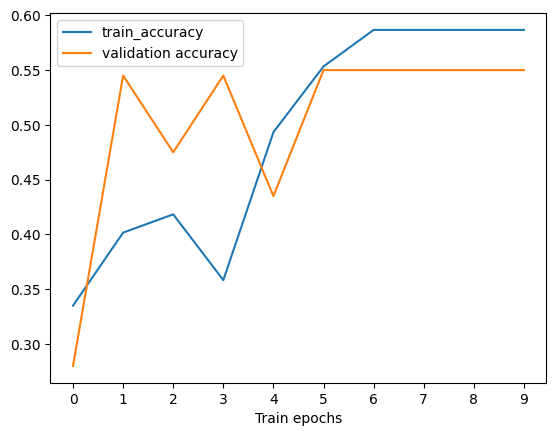

Training accuracy: 0.5867
Validation accuracy: 0.5500


In [46]:
class_model = train_and_evaluate()

/Users/woojungkim/Library/Caches/pypoetry/virtualenvs/datasci207-bird-sounds-l5dSQ9Ay-py3.10/lib/python3.10/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Training the {'1139490-CSA36385': array([[0.7049017 , 0.7199734 , 0.7997811 , ..., 0.734428  , 0.67589897,
        0.68217033],
       [0.7055023 , 0.71459347, 0.8169817 , ..., 0.7200174 , 0.6759654 ,
        0.669133  ],
       [0.7067035 , 0.7038336 , 0.85138285, ..., 0.69119614, 0.6760983 ,
        0.6430584 ],
       ...,
       [0.21929455, 0.24594526, 0.24758169, ..., 0.24455921, 0.23815045,
        0.25762546],
       [0.21801785, 0.24828465, 0.24967664, ..., 0.244798  , 0.24452555,
        0.25601286],
       [0.2173795 , 0.24945435, 0.25072414, ..., 0.24491741, 0.2477131 ,
        0.25520656]], dtype=float32), '1139490-CSA36389': array([[0.6860932 , 0.63555586, 0.6695411 , ..., 0.83289945, 0.8271354 ,
        0.7059211 ],
       [0.68805015, 0.63310075, 0.66653323, ..., 0.8213653 , 0.82061225,
        0.71397114],
       [0.6919639 , 0.6281904 , 0.6605174 , ..., 0.7982969 , 0.80756605,
        0.73007125],
       ...,
       [0.2316096 , 0.25438875, 0.24364811, ..., 0.20537263

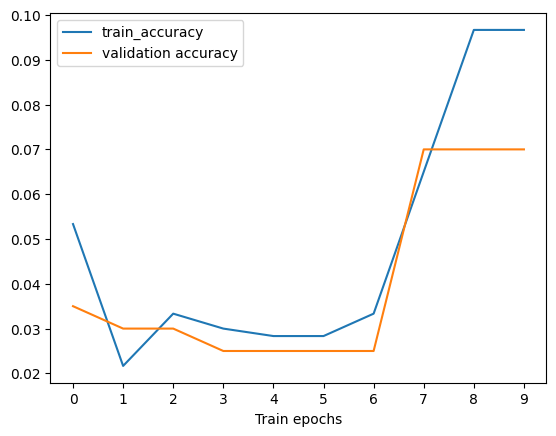

Training accuracy: 0.0967
Validation accuracy: 0.0700


In [53]:
specs_model = train_and_evaluate(n_classes= 600, type = "species")

### Model training


Running config: class, [128]
Training the 

/Users/woojungkim/Library/Caches/pypoetry/virtualenvs/datasci207-bird-sounds-l5dSQ9Ay-py3.10/lib/python3.10/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


{'1139490-CSA36385': array([[0.7049017 , 0.7199734 , 0.7997811 , ..., 0.734428  , 0.67589897,
        0.68217033],
       [0.7055023 , 0.71459347, 0.8169817 , ..., 0.7200174 , 0.6759654 ,
        0.669133  ],
       [0.7067035 , 0.7038336 , 0.85138285, ..., 0.69119614, 0.6760983 ,
        0.6430584 ],
       ...,
       [0.21929455, 0.24594526, 0.24758169, ..., 0.24455921, 0.23815045,
        0.25762546],
       [0.21801785, 0.24828465, 0.24967664, ..., 0.244798  , 0.24452555,
        0.25601286],
       [0.2173795 , 0.24945435, 0.25072414, ..., 0.24491741, 0.2477131 ,
        0.25520656]], dtype=float32), '1139490-CSA36389': array([[0.6860932 , 0.63555586, 0.6695411 , ..., 0.83289945, 0.8271354 ,
        0.7059211 ],
       [0.68805015, 0.63310075, 0.66653323, ..., 0.8213653 , 0.82061225,
        0.71397114],
       [0.6919639 , 0.6281904 , 0.6605174 , ..., 0.7982969 , 0.80756605,
        0.73007125],
       ...,
       [0.2316096 , 0.25438875, 0.24364811, ..., 0.20537263, 0.20583257,

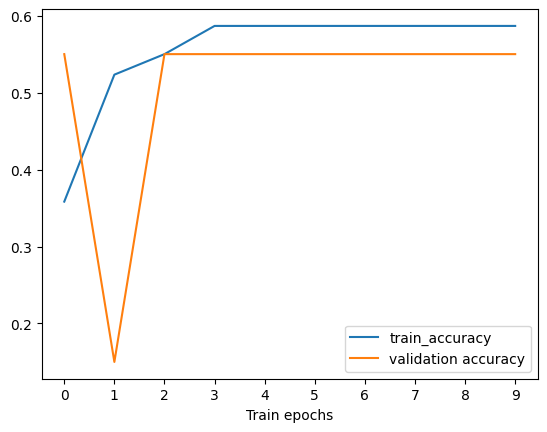

Training accuracy: 0.5867
Validation accuracy: 0.5500

Running config: class, [256, 128]
Training the {'1139490-CSA36385': array([[0.7049017 , 0.7199734 , 0.7997811 , ..., 0.734428  , 0.67589897,
        0.68217033],
       [0.7055023 , 0.71459347, 0.8169817 , ..., 0.7200174 , 0.6759654 ,
        0.669133  ],
       [0.7067035 , 0.7038336 , 0.85138285, ..., 0.69119614, 0.6760983 ,
        0.6430584 ],
       ...,
       [0.21929455, 0.24594526, 0.24758169, ..., 0.24455921, 0.23815045,
        0.25762546],
       [0.21801785, 0.24828465, 0.24967664, ..., 0.244798  , 0.24452555,
        0.25601286],
       [0.2173795 , 0.24945435, 0.25072414, ..., 0.24491741, 0.2477131 ,
        0.25520656]], dtype=float32), '1139490-CSA36389': array([[0.6860932 , 0.63555586, 0.6695411 , ..., 0.83289945, 0.8271354 ,
        0.7059211 ],
       [0.68805015, 0.63310075, 0.66653323, ..., 0.8213653 , 0.82061225,
        0.71397114],
       [0.6919639 , 0.6281904 , 0.6605174 , ..., 0.7982969 , 0.80756605,
   

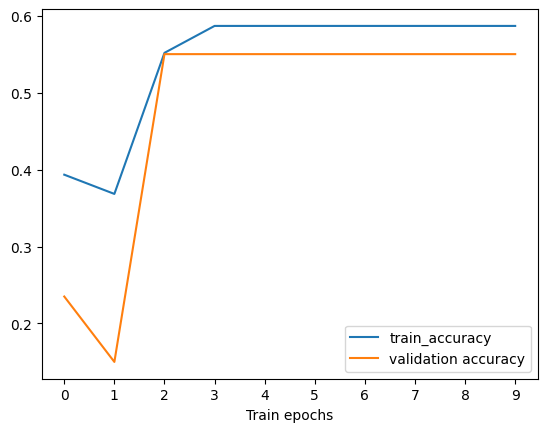

Training accuracy: 0.5867
Validation accuracy: 0.5500

Running config: species, [128]
Training the {'1139490-CSA36385': array([[0.7049017 , 0.7199734 , 0.7997811 , ..., 0.734428  , 0.67589897,
        0.68217033],
       [0.7055023 , 0.71459347, 0.8169817 , ..., 0.7200174 , 0.6759654 ,
        0.669133  ],
       [0.7067035 , 0.7038336 , 0.85138285, ..., 0.69119614, 0.6760983 ,
        0.6430584 ],
       ...,
       [0.21929455, 0.24594526, 0.24758169, ..., 0.24455921, 0.23815045,
        0.25762546],
       [0.21801785, 0.24828465, 0.24967664, ..., 0.244798  , 0.24452555,
        0.25601286],
       [0.2173795 , 0.24945435, 0.25072414, ..., 0.24491741, 0.2477131 ,
        0.25520656]], dtype=float32), '1139490-CSA36389': array([[0.6860932 , 0.63555586, 0.6695411 , ..., 0.83289945, 0.8271354 ,
        0.7059211 ],
       [0.68805015, 0.63310075, 0.66653323, ..., 0.8213653 , 0.82061225,
        0.71397114],
       [0.6919639 , 0.6281904 , 0.6605174 , ..., 0.7982969 , 0.80756605,
      

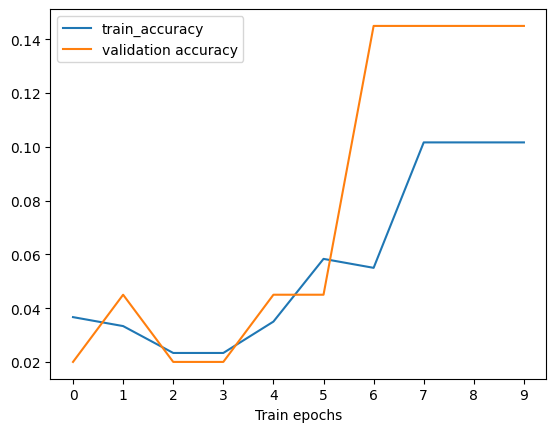

Training accuracy: 0.1017
Validation accuracy: 0.1450

Running config: species, [256, 128]
Training the {'1139490-CSA36385': array([[0.7049017 , 0.7199734 , 0.7997811 , ..., 0.734428  , 0.67589897,
        0.68217033],
       [0.7055023 , 0.71459347, 0.8169817 , ..., 0.7200174 , 0.6759654 ,
        0.669133  ],
       [0.7067035 , 0.7038336 , 0.85138285, ..., 0.69119614, 0.6760983 ,
        0.6430584 ],
       ...,
       [0.21929455, 0.24594526, 0.24758169, ..., 0.24455921, 0.23815045,
        0.25762546],
       [0.21801785, 0.24828465, 0.24967664, ..., 0.244798  , 0.24452555,
        0.25601286],
       [0.2173795 , 0.24945435, 0.25072414, ..., 0.24491741, 0.2477131 ,
        0.25520656]], dtype=float32), '1139490-CSA36389': array([[0.6860932 , 0.63555586, 0.6695411 , ..., 0.83289945, 0.8271354 ,
        0.7059211 ],
       [0.68805015, 0.63310075, 0.66653323, ..., 0.8213653 , 0.82061225,
        0.71397114],
       [0.6919639 , 0.6281904 , 0.6605174 , ..., 0.7982969 , 0.80756605,
 

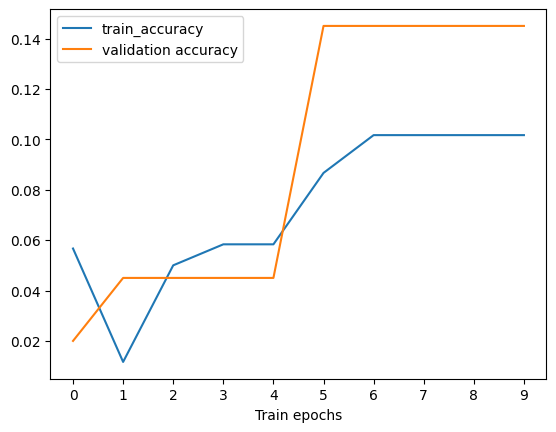

Training accuracy: 0.1017
Validation accuracy: 0.1450


In [57]:
table = [
    ("class", [128], 4),
    ("class", [256, 128], 4),
    ("species", [128], 600),
    ("species", [256, 128], 600)
]

for types, hidden, n_class in table:
    print(f"\nRunning config: {types}, {hidden}")
    model = train_and_evaluate(type = types, hidden_layer_sizes=hidden, n_classes=n_class)